### 3.4. Расчёт LTV в Python

### Подготовка

Определим некоторые функции, написанные в предыдущих уроках:

In [ ]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Чтобы рассчитать LTV (ARPU) на языке Python, понадобятся профили пользователей и данные о стоимости совершённых покупок.

#### Как рассчитать LTV в Python

- Получить пользовательские профили и данные о покупках.
- Добавить данные о покупках в профили.
- Рассчитать лайфтайм пользователя для каждой покупки.
- Построить таблицу выручки. То есть сводную таблицу, в которой названия строк — это даты первого посещения пользователей, названия столбцов — лайфтайм, а значения в «ячейках» — выручка.
- Посчитать сумму с накоплением для каждой строки таблицы выручки.
- Вычислить размеры когорт и занести результаты в отдельную таблицу.
- Объединить таблицы размеров когорт и выручки.
- Посчитать LTV: разделить каждую «ячейку» таблицы выручки на соответствующий размер когорты.

Алгоритм практически совпадает со способом расчёта конверсии, поэтому мы можем адаптировать функцию `get_conversion()` для расчёта конверсии из предыдущей темы к расчёту «пожизненной ценности» клиентов.

Для этого переименуем функцию в `get_ltv()`, удалим расчёт времени первой покупки, добавим в профили столбец `revenue` из данных о покупках, а затем агрегируем значения этого столбца при построении «треугольной» таблицы выручки.

In [ ]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

Функция для расчёта LTV готова. Передадим ей данные книжного онлайн-магазина «Читать не вредно» из предыдущей темы и построим тепловую карту по таблице LTV. Момент и горизонт анализа данных прежние — 13 мая 2019 года и 7 дней соответственно.

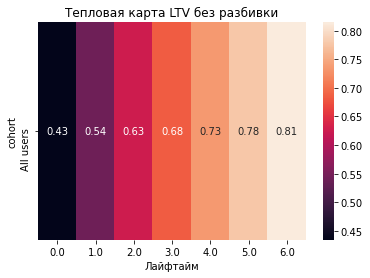

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

profiles = pd.read_csv('/datasets/profiles.csv')  # профили
orders = pd.read_csv('/datasets/book_orders.csv')  # данные о покупках

# преобразуем данные о времени
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 5, 13).date(), 7
)

sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f')
plt.title('Тепловая карта LTV без разбивки')
plt.xlabel('Лайфтайм')
plt.show()

Выручка в данных о покупках «Читать не вредно» записана в долларах — недельный LTV пользователей, зарегистрировавшихся в начале мая, составил 81 цент. 

#### Кривые LTV

По LTV, как и по Retention Rate, Churn Rate и Conversion Rate, можно строить кривые.

Разобьём LTV по странам и построим кривые «пожизненной ценности» пользователей сайта «Читать не вредно». Передадим параметру `dimensions` столбец `region`, исключим из таблицы LTV размеры когорт методом `drop()`, транспонируем её и построим график методом `plot()`.

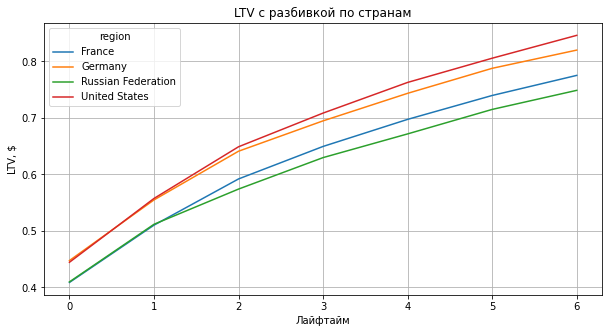

In [ ]:
# строим кривые LTV

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 5, 13).date(), 7, dimensions=['region']
)

report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по странам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

Судя по графику, самый высокий LTV — у пользователей из США. Затем идут Германия и Франция. Пользователи из России приносят магазину меньше всего выручки.

#### Динамика LTV

Теперь изучим LTV в динамике. Построим график истории изменений LTV на первый, пятый и седьмой дни «жизни» пользователей по таблице из `ltv_history`.

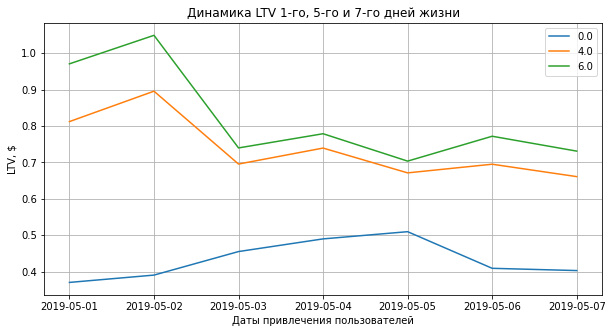

In [ ]:
# строим график истории изменений LTV

ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 5, 13).date(), 7
)

report = ltv_history[[0, 4, 6]]  # делаем срез данных
report.plot(grid=True, figsize=(10, 5))
plt.title('Динамика LTV 1-го, 5-го и 7-го дней жизни')
plt.ylabel('LTV, $')
plt.xlabel('Даты привлечения пользователей')
plt.show()

Любопытно: для пользователей, привлечённых между 2 и 6 мая, LTV первого дня, отражённый на нижней линии, растёт, а LTV пятого и седьмого дня (средняя и верхняя линии), наоборот, падает.

Проверим одно из предположений — о привлечении пользователей, которые много покупали, но быстро «отваливались». Для этого рассчитаем удержание написанной ранее функцией `get_retention()` и построим график истории изменений удержания на пятый и седьмой дни только для платящих пользователей.

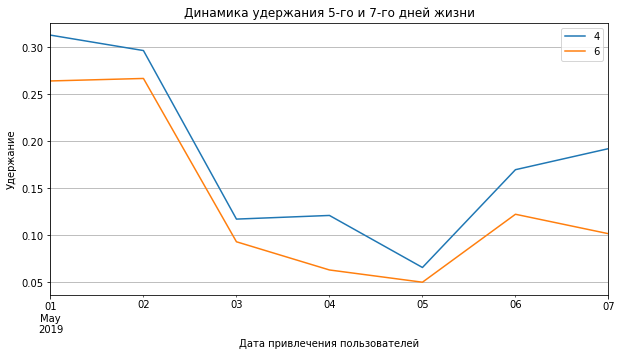

In [ ]:
# динамика удержания платящих пользователей на 5-й, 7-й дни

sessions = pd.read_csv('/datasets/sessions.csv')
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

retention_raw, retention, retention_history = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 7
)

report = retention_history.query('payer == True').droplevel('payer')[[4, 6]]
report.plot(grid=True, figsize=(10, 5))
plt.title('Динамика удержания 5-го и 7-го дней жизни')
plt.ylabel('Удержание')
plt.xlabel('Дата привлечения пользователей')
plt.show()

Похоже, предположение подтвердилось: падение удержания платящих пользователей совпадает по времени со снижением LTV пятого и седьмого дней.